## Import Library

In [ ]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [ ]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

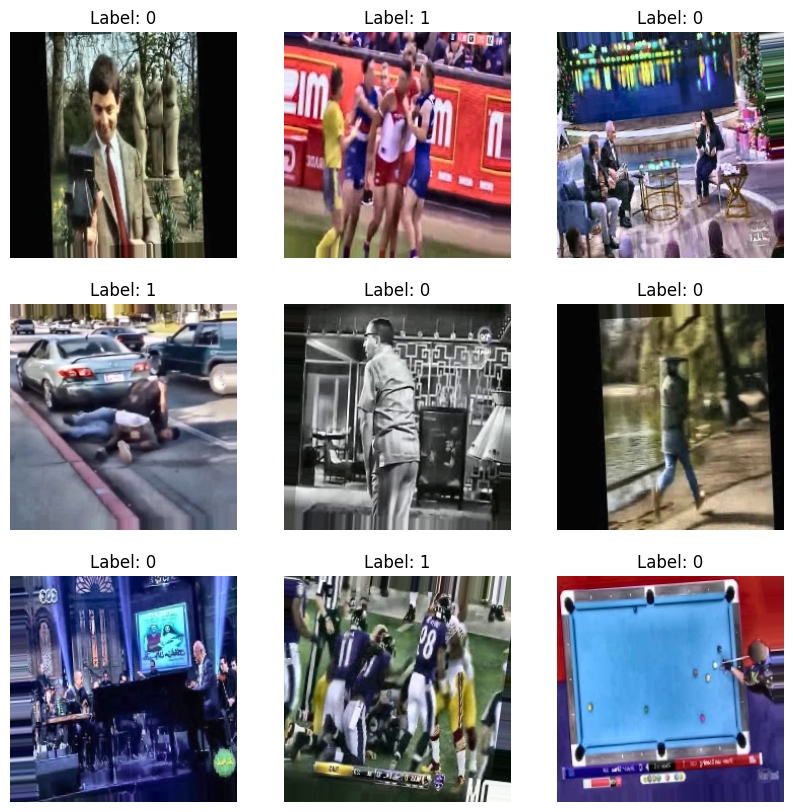

In [ ]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [ ]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 40
for layer in base_model.layers[:40]:
    layer.trainable = False
for layer in base_model.layers[40:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_Freeze40_0.001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.7130 - loss: 1.1393
Epoch 1: val_accuracy improved from -inf to 0.52273, saving model to MCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 56s 838ms/step - accuracy: 0.7139 - loss: 1.1363 - val_accuracy: 0.5227 - val_loss: 0.9954
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8276 - loss: 0.7481
Epoch 2: val_accuracy improved from 0.52273 to 0.62273, saving model to MCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 580ms/step - accuracy: 0.8278 - loss: 0.7476 - val_accuracy: 0.6227 - val_loss: 0.8933
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8711 - loss: 0.6739
Epoch 3: val_accuracy improved from 0.62273 to 0.84091, saving model to MCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 554ms/step - accuracy: 0.8709 - loss: 0.6740 - val_accuracy: 0.8409 - val_loss: 0.7201
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8836 - loss: 0.5714
Epoch 4: val_accuracy did not improve from 0.84091
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 552ms/step - accuracy: 0.8834 - loss: 0.5719 - val_accuracy: 0.8159 - val_loss: 0.6902
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8643 - loss: 0.6208
Epoch 5: val_accuracy did not improve from 0.84091
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 548ms/step - accuracy: 0.8644 - loss: 0.6206 - val_accuracy: 0.7818 - val_loss: 0.7005
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8799 - loss: 0.5698
Epoch 6: val_accuracy did not improve from 0.84091
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 546ms/step - accuracy: 0.8800 - loss: 0.5698 - val_accuracy: 0.8386 - val_loss: 0.6304
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8999 - loss: 0.5249
Epoch 7: val_accuracy improved 

49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 556ms/step - accuracy: 0.8998 - loss: 0.5249 - val_accuracy: 0.8795 - val_loss: 0.5363
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9036 - loss: 0.4778
Epoch 8: val_accuracy improved from 0.87955 to 0.89773, saving model to MCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 537ms/step - accuracy: 0.9036 - loss: 0.4778 - val_accuracy: 0.8977 - val_loss: 0.4726
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9161 - loss: 0.4603
Epoch 9: val_accuracy did not improve from 0.89773
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 552ms/step - accuracy: 0.9159 - loss: 0.4605 - val_accuracy: 0.8864 - val_loss: 0.4694
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8963 - loss: 0.4978
Epoch 10: val_accuracy did not improve from 0.89773
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 555ms/step - accuracy: 0.8966 - loss: 0.4973 - val_accuracy: 0.8773 - val_loss: 0.5352
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8972 - loss: 0.4700
Epoch 11: val_accuracy improved from 0.89773 to 0.92273, saving model to MCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.8975 - loss: 0.4696 - val_accuracy: 0.9227 - val_loss: 0.4128
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9196 - loss: 0.4298
Epoch 12: val_accuracy did not improve from 0.92273
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 558ms/step - accuracy: 0.9196 - loss: 0.4299 - val_accuracy: 0.9091 - val_loss: 0.4366
Epoch 13/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9157 - loss: 0.4294
Epoch 13: val_accuracy did not improve from 0.92273
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 554ms/step - accuracy: 0.9158 - loss: 0.4292 - val_accuracy: 0.9205 - val_loss: 0.4566
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9136 - loss: 0.4249
Epoch 14: val_accuracy did not improve from 0.92273
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 557ms/step - accuracy: 0.9137 - loss: 0.4248 - val_accuracy: 0.9136 - val_loss: 0.4189
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9236 - loss: 0.4021
Epoch 15: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 552ms/step - accuracy: 0.9210 - loss: 0.4004 - val_accuracy: 0.9273 - val_loss: 0.3945
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9200 - loss: 0.3913
Epoch 23: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 548ms/step - accuracy: 0.9202 - loss: 0.3910 - val_accuracy: 0.9273 - val_loss: 0.3918
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9255 - loss: 0.3730
Epoch 24: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 535ms/step - accuracy: 0.9255 - loss: 0.3733 - val_accuracy: 0.9023 - val_loss: 0.4487
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9340 - loss: 0.3739
Epoch 25: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 550ms/step - accuracy: 0.9339 - loss: 0.3740 - val_accuracy: 0.8727 - val_loss: 0.4860
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9181 - loss: 0.3871
Epoch 26: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 559ms/step - accuracy: 0.9207 - loss: 0.4007 - val_accuracy: 0.9295 - val_loss: 0.3844
Epoch 28/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9198 - loss: 0.3966
Epoch 28: val_accuracy did not improve from 0.92955
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 557ms/step - accuracy: 0.9199 - loss: 0.3962 - val_accuracy: 0.9273 - val_loss: 0.3785
Epoch 29/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9326 - loss: 0.3609
Epoch 29: val_accuracy did not improve from 0.92955
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 556ms/step - accuracy: 0.9326 - loss: 0.3608 - val_accuracy: 0.8818 - val_loss: 0.5136
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9311 - loss: 0.3816
Epoch 30: val_accuracy did not improve from 0.92955
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step - accuracy: 0.9310 - loss: 0.3814 - val_accuracy: 0.9227 - val_loss: 0.3726
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9228 - loss: 0.3798
Epoch 31: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 553ms/step - accuracy: 0.9400 - loss: 0.3098 - val_accuracy: 0.9341 - val_loss: 0.3674
Epoch 38/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9374 - loss: 0.3328
Epoch 38: val_accuracy did not improve from 0.93409
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 551ms/step - accuracy: 0.9372 - loss: 0.3331 - val_accuracy: 0.9227 - val_loss: 0.3404
Epoch 39/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9348 - loss: 0.3035
Epoch 39: val_accuracy did not improve from 0.93409
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 563ms/step - accuracy: 0.9348 - loss: 0.3039 - val_accuracy: 0.9091 - val_loss: 0.3717
Epoch 40/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9385 - loss: 0.3112
Epoch 40: val_accuracy did not improve from 0.93409
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 537ms/step - accuracy: 0.9384 - loss: 0.3114 - val_accuracy: 0.9159 - val_loss: 0.3476
Epoch 41/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9366 - loss: 0.3280
Epoch 41: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 555ms/step - accuracy: 0.9373 - loss: 0.3063 - val_accuracy: 0.9364 - val_loss: 0.3290
Epoch 47/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9429 - loss: 0.3224
Epoch 47: val_accuracy did not improve from 0.93636
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 552ms/step - accuracy: 0.9429 - loss: 0.3222 - val_accuracy: 0.8977 - val_loss: 0.3818
Epoch 48/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9476 - loss: 0.2845
Epoch 48: val_accuracy did not improve from 0.93636
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 550ms/step - accuracy: 0.9475 - loss: 0.2847 - val_accuracy: 0.9341 - val_loss: 0.3394
Epoch 49/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9401 - loss: 0.2896
Epoch 49: val_accuracy did not improve from 0.93636
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 549ms/step - accuracy: 0.9400 - loss: 0.2897 - val_accuracy: 0.9318 - val_loss: 0.3173
Epoch 50/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9459 - loss: 0.2987
Epoch 50: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.8479 - loss: 0.5991
Validation Loss: 0.43551674485206604
Validation Accuracy: 0.8999999761581421


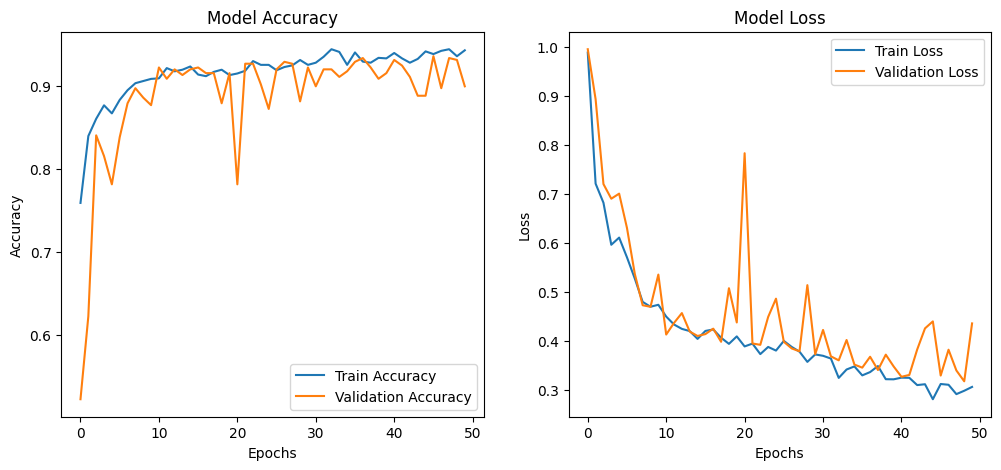

In [ ]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [ ]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_Freeze40_0.001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9353 - loss: 0.3309
Test Accuracy : 93.69%
Test Loss     : 0.313


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step


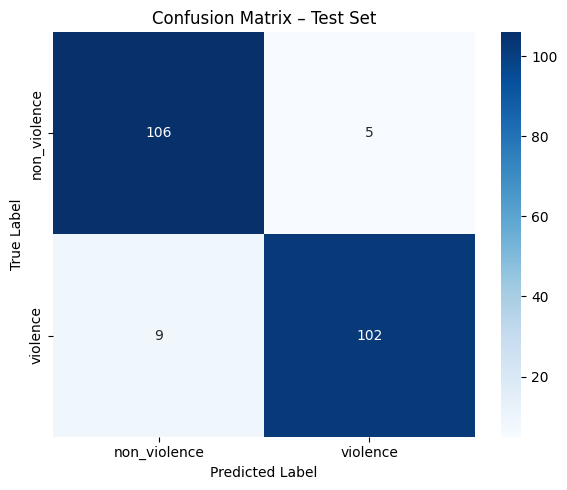


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.92      0.95      0.94       111
    violence       0.95      0.92      0.94       111

    accuracy                           0.94       222
   macro avg       0.94      0.94      0.94       222
weighted avg       0.94      0.94      0.94       222



In [ ]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))